**Task 3: Customer Segmentation / Clustering**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets
customers = pd.read_csv('/content/Customers.csv')
transactions = pd.read_csv('/content/Transactions.csv')

**Using both profile information(from Customers.csv) and transaction information (from Transactions.csv)**

In [3]:
# Merge datasets
customer_transactions = transactions.merge(customers, on="CustomerID", how="left")

# Display enriched transactions data
print("\nEnriched Transactions Data:")
display(customer_transactions.head())



Enriched Transactions Data:


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15


**Feature Engineering**


In [4]:
# Feature Engineering
# Aggregate transactional data
agg_transactions = customer_transactions.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    avg_transaction_value=('TotalValue', 'mean'),
    total_transactions=('TransactionID', 'count'),
    unique_categories=('ProductID', pd.Series.nunique)
).reset_index()

In [5]:
# Merge profile information
customer_data = customers.merge(agg_transactions, on='CustomerID', how='left')

# Display enriched transactions data
print("\nCustomer Data:")
display(customer_data.head())


Customer Data:


,CustomerID,CustomerName,Region,SignupDate,total_spend,avg_transaction_value,total_transactions,unique_categories
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,670.904,5.0,5.0
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,465.685,4.0,4.0
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,681.345,4.0,4.0
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,669.360,8.0,8.0
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,678.080,3.0,3.0


In [6]:
# Fill missing values (if any)
customer_data.fillna(0, inplace=True)

# Normalize numeric features
features = ['total_spend', 'avg_transaction_value', 'total_transactions', 'unique_categories']
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[features])

**Using K-means Clustering for simplicity and scalability**

**Elbow Method and Davies-Bouldin Index (DB Index)**

In [7]:
# Clustering: KMeans
# Experiment with clusters (2–10)
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(customer_data_scaled)
    db_index = davies_bouldin_score(customer_data_scaled, labels)
    db_scores.append(db_index)
    print(f"Number of Clusters: {k}, DB Index: {db_index:.3f}")

# Optimal number of clusters (based on DB Index)
optimal_k = np.argmin(db_scores) + 2
print(f"Optimal number of clusters: {optimal_k}")

# Perform clustering with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)


Number of Clusters: 2, DB Index: 0.963
Number of Clusters: 3, DB Index: 1.042
Number of Clusters: 4, DB Index: 0.877
Number of Clusters: 5, DB Index: 0.892
Number of Clusters: 6, DB Index: 0.908
Number of Clusters: 7, DB Index: 0.850
Number of Clusters: 8, DB Index: 0.851
Number of Clusters: 9, DB Index: 0.865
Number of Clusters: 10, DB Index: 0.829
Optimal number of clusters: 10


In [10]:
# Evaluate clustering
sil_score = silhouette_score(customer_data_scaled, customer_data['Cluster'])
print(f"Silhouette Score: {sil_score:.3f}")

Silhouette Score: 0.372


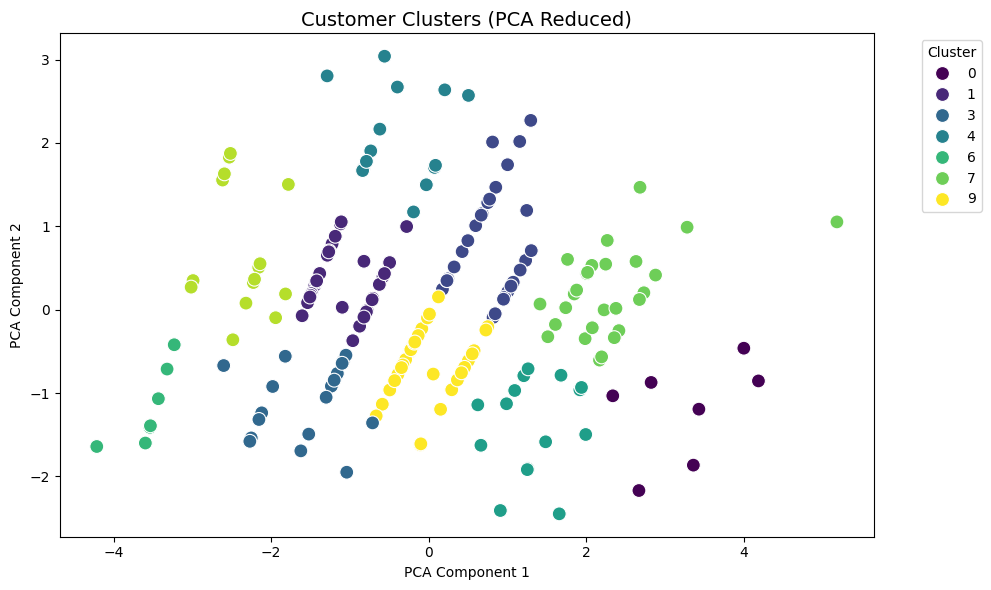

In [9]:
# Visualize clusters
pca = PCA(n_components=2)
pca_components = pca.fit_transform(customer_data_scaled)
customer_data['PCA1'] = pca_components[:, 0]
customer_data['PCA2'] = pca_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=customer_data, palette='viridis', s=100
)
plt.title('Customer Clusters (PCA Reduced)', fontsize=14)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()